# Feature Engineering

In this notebook we're going to generate features for our link prediction classifier.

In [1]:
from neo4j import GraphDatabase

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# tag::imports[]
from sklearn.ensemble import RandomForestClassifier
# end::imports[]

In [2]:
bolt_uri = "bolt://link-prediction-neo4j"
driver = GraphDatabase.driver(bolt_uri, auth=("neo4j", "admin"))

print(driver.address)

link-prediction-neo4j:7687


We can create our classifier with the following code:

In [42]:
# Load the CSV files saved in the train/test notebook

df_train_under = pd.read_csv("data/df_train_under.csv")
df_test_under = pd.read_csv("data/df_test_under.csv")

In [43]:
df_train_under.sample(5)

,node1,node2,label
155499,170048,246553,1
72203,217564,134794,0
27931,106455,35483,0
61237,27080,36559,0
65103,248868,256441,0


In [23]:
df_test_under.sample(5)

,node1,node2,label
145612,2311,260455,1
39218,180150,209959,0
97388,44011,140376,1
97883,100949,144941,1
64958,145397,139871,0


# Generating graphy features

We’ll start by creating a simple model that tries to predict whether two authors will have a future collaboration based on features extracted from common authors, preferential attachment, and the total union of neighbors.

The following function computes each of these measures for pairs of nodes:

In [9]:
# tag::graphy-features[]
def apply_graphy_features(data, rel_type):
    query = """
    UNWIND $pairs AS pair
    MATCH (p1) WHERE id(p1) = pair.node1
    MATCH (p2) WHERE id(p2) = pair.node2
    RETURN pair.node1 AS node1,
           pair.node2 AS node2,
           gds.alpha.linkprediction.commonNeighbors(p1, p2, {
             relationshipQuery: $relType}) AS cn,
           gds.alpha.linkprediction.preferentialAttachment(p1, p2, {
             relationshipQuery: $relType}) AS pa,
           gds.alpha.linkprediction.totalNeighbors(p1, p2, {
             relationshipQuery: $relType}) AS tn
    """
    pairs = [{"node1": node1, "node2": node2}  for node1,node2 in data[["node1", "node2"]].values.tolist()]
    
    with driver.session(database="neo4j") as session:
        result = session.run(query, {"pairs": pairs, "relType": rel_type})
        features = pd.DataFrame([dict(record) for record in result])    
    return pd.merge(data, features, on = ["node1", "node2"])
# end::graphy-features[]

Let's apply the function to our training DataFrame:

In [44]:
# tag::apply-graphy-features[]
df_train_under = apply_graphy_features(df_train_under, "CO_AUTHOR_EARLY")
df_test_under = apply_graphy_features(df_test_under, "CO_AUTHOR")
# end::apply-graphy-features[]

Now we're going to add some new features that are generated from graph algorithms.

## Triangles and The Clustering Coefficient

We'll start by running the [triangle count](clusteringCoefficientProperty) algorithm over our test and train sub graphs. This algorithm will return the number of triangles that each node forms, as well as each node's clustering coefficient. The clustering coefficient of a node indicates the likelihood that its neighbours are also connected.

In [48]:
query = """
CALL gds.triangleCount.write({
  nodeProjection: 'Author',
  relationshipProjection: {
    CO_AUTHOR_EARLY: {
      type: 'CO_AUTHOR_EARLY',
      orientation: 'UNDIRECTED'
    }
  },
  writeProperty: 'trianglesTrain'
});
"""

with driver.session(database="neo4j") as session:
    result = session.run(query)
    df = pd.DataFrame([dict(record) for record in result])
df

,nodePropertiesWritten,writeMillis,globalTriangleCount,nodeCount,createMillis,computeMillis,configuration
0,80299,55,92296,80299,43,13,"{'writeConcurrency': 4, 'writeProperty': 'tria..."


In [49]:
query = """
CALL gds.triangleCount.write({
  nodeProjection: 'Author',
  relationshipProjection: {
    CO_AUTHOR: {
      type: 'CO_AUTHOR',
      orientation: 'UNDIRECTED'
    }
  },
  writeProperty: 'trianglesTest'
});
"""

with driver.session(database="neo4j") as session:
    result = session.run(query)
    df = pd.DataFrame([dict(record) for record in result])
df    

,nodePropertiesWritten,writeMillis,globalTriangleCount,nodeCount,createMillis,computeMillis,configuration
0,80299,219,183856,80299,34,21,"{'writeConcurrency': 4, 'writeProperty': 'tria..."


In [50]:
query = """
CALL gds.localClusteringCoefficient.write({
  nodeProjection: 'Author',
  relationshipProjection: {
    CO_AUTHOR_EARLY: {
      type: 'CO_AUTHOR',
      orientation: 'UNDIRECTED'
    }
  },
  writeProperty: 'coefficientTest'
});
"""

with driver.session(database="neo4j") as session:
    result = session.run(query)
    df = pd.DataFrame([dict(record) for record in result])
df

,nodePropertiesWritten,writeMillis,averageClusteringCoefficient,nodeCount,createMillis,computeMillis,configuration
0,80299,38,0.627,80299,34,23,"{'writeConcurrency': 4, 'triangleCountProperty..."


In [ ]:
The following function will add these features to our train and test DataFrames:

In [38]:
def apply_triangles_features(data, triangles_prop, coefficient_prop):
    query = """
    UNWIND $pairs AS pair
    MATCH (p1) WHERE id(p1) = pair.node1
    MATCH (p2) WHERE id(p2) = pair.node2
    RETURN pair.node1 AS node1,
    pair.node2 AS node2,
    apoc.coll.min([p1[$trianglesProp], p2[$trianglesProp]]) AS minTriangles,
    apoc.coll.max([p1[$trianglesProp], p2[$trianglesProp]]) AS maxTriangles,
    apoc.coll.min([p1[$coefficientProp], p2[$coefficientProp]]) AS minCoefficient,
    apoc.coll.max([p1[$coefficientProp], p2[$coefficientProp]]) AS maxCoefficient
    """    
    pairs = [{"node1": node1, "node2": node2}  for node1,node2 in data[["node1", "node2"]].values.tolist()]    
    params = {
    "pairs": pairs,
    "trianglesProp": triangles_prop,
    "coefficientProp": coefficient_prop
    }

    with driver.session(database="neo4j") as session:
        result = session.run(query, params)
        features = pd.DataFrame([dict(record) for record in result])       
    
    return pd.merge(data, features, on = ["node1", "node2"])

In [51]:
df_train_under = apply_triangles_features(df_train_under, "trianglesTrain", "coefficientTrain")
df_test_under = apply_triangles_features(df_test_under, "trianglesTest", "coefficientTest")

In [52]:
df_train_under.sample(5)

,node1,node2,label,cn,pa,tn,minTriangles,maxTriangles,minCoefficient,maxCoefficient
158431,52568,256631,1,5.000,36.000,7.000,15,15,1.000,1.000
95264,44429,44431,1,4.000,25.000,6.000,10,10,1.000,1.000
96418,45176,45177,1,3.000,35.000,9.000,7,12,0.571,0.700
7114,57903,84305,0,0.000,12.000,8.000,1,4,0.200,1.000
32796,1817,11816,0,0.000,16.000,8.000,2,2,0.333,0.333


In [53]:
df_test_under.sample(5)

,node1,node2,label,cn,pa,tn,minTriangles,maxTriangles,minCoefficient,maxCoefficient
147441,263311,263312,1,2.000,9.000,4.000,3,3,1.000,1.000
82615,2339,58544,1,4.000,75.000,16.000,10,17,0.162,1.000
48008,183931,155840,0,1.000,40.000,13.000,5,29,0.667,0.833
115943,156587,192251,1,7.000,99.000,13.000,27,33,0.582,0.778
94853,129942,129943,1,5.000,36.000,7.000,15,15,1.000,1.000


## Community Detection

Community detection algorithms evaluate how a group is clustered or partitioned. Nodes are considered more similar to nodes that fall in their community than to nodes in other communities.

We'll run two community detection algorithms over the train and test sub graphs - Label Propagation and Louvain. First up, Label Propagation: 

In [54]:
query = """
CALL gds.labelPropagation.write({
  nodeProjection: "Author",
  relationshipProjection: {
    CO_AUTHOR_EARLY: {
      type: 'CO_AUTHOR_EARLY',
      orientation: 'UNDIRECTED'
    }
  },
  writeProperty: "partitionTrain"
});
"""

with driver.session(database="neo4j") as session:
    result = session.run(query)
    df = pd.DataFrame([dict(record) for record in result])
df    

,nodePropertiesWritten,createMillis,computeMillis,writeMillis,postProcessingMillis,communityCount,ranIterations,didConverge,communityDistribution,configuration
0,80299,20,143,194,18,43685,8,True,"{'p99': 15, 'min': 1, 'max': 214, 'mean': 1.83...","{'maxIterations': 10, 'writeConcurrency': 4, '..."


In [55]:
query = """
CALL gds.labelPropagation.write({
  nodeProjection: "Author",
  relationshipProjection: {
    CO_AUTHOR: {
      type: 'CO_AUTHOR',
      orientation: 'UNDIRECTED'
    }
  },
  writeProperty: "partitionTest"
});
"""

with driver.session(database="neo4j") as session:
    result = session.run(query)
    df = pd.DataFrame([dict(record) for record in result])
df    

,nodePropertiesWritten,createMillis,computeMillis,writeMillis,postProcessingMillis,communityCount,ranIterations,didConverge,communityDistribution,configuration
0,80299,30,95,126,3,15753,8,True,"{'p99': 42, 'min': 1, 'max': 417, 'mean': 5.09...","{'maxIterations': 10, 'writeConcurrency': 4, '..."


In [56]:
query = """
CALL gds.louvain.stream({
  nodeProjection: 'Author',
  relationshipProjection: {
    CO_AUTHOR_EARLY: {
      type: 'CO_AUTHOR_EARLY',
      orientation: 'UNDIRECTED'
    }
  },
  includeIntermediateCommunities: true
})
YIELD nodeId, communityId, intermediateCommunityIds
WITH gds.util.asNode(nodeId) AS node, intermediateCommunityIds[0] AS smallestCommunity
SET node.louvainTrain = smallestCommunity;
"""

with driver.session(database="neo4j") as session:
    display(session.run(query).consume().counters)

{'properties_set': 80299}

In [57]:
query = """
CALL gds.louvain.stream({
  nodeProjection: 'Author',
  relationshipProjection: {
    CO_AUTHOR: {
      type: 'CO_AUTHOR',
      orientation: 'UNDIRECTED'
    }
  },
  includeIntermediateCommunities: true
})
YIELD nodeId, communityId, intermediateCommunityIds
WITH gds.util.asNode(nodeId) AS node, intermediateCommunityIds[0] AS smallestCommunity
SET node.louvainTest = smallestCommunity;
"""

with driver.session(database="neo4j") as session:
    display(session.run(query).consume().counters)

{'properties_set': 80299}

In [58]:
def apply_community_features(data, partition_prop, louvain_prop):
    query = """
    UNWIND $pairs AS pair
    MATCH (p1) WHERE id(p1) = pair.node1
    MATCH (p2) WHERE id(p2) = pair.node2
    RETURN pair.node1 AS node1,
    pair.node2 AS node2,
    gds.alpha.linkprediction.sameCommunity(p1, p2, $partitionProp) AS sp,    
    gds.alpha.linkprediction.sameCommunity(p1, p2, $louvainProp) AS sl
    """
    pairs = [{"node1": node1, "node2": node2}  for node1,node2 in data[["node1", "node2"]].values.tolist()]
    params = {
    "pairs": pairs,
    "partitionProp": partition_prop,
    "louvainProp": louvain_prop
    }
    
    with driver.session(database="neo4j") as session:
        result = session.run(query, params)
        features = pd.DataFrame([dict(record) for record in result])
    
    return pd.merge(data, features, on = ["node1", "node2"])

In [59]:
df_train_under = apply_community_features(df_train_under, "partitionTrain", "louvainTrain")
df_test_under = apply_community_features(df_test_under, "partitionTest", "louvainTest")

In [68]:
# tag::train-after-features[]
df_train_under.sample(5)
# end::train-after-features[]

,node1,node2,label,cn,pa,tn,minTriangles,maxTriangles,minCoefficient,maxCoefficient,sp,sl
161858,201253,263475,1,0.000,3.000,4.000,0,1,0.000,0.333,1.000,1.000
109224,3399,83788,1,3.000,80.000,21.000,6,24,0.126,1.000,1.000,1.000
13299,52633,18891,0,0.000,10.000,7.000,1,10,1.000,1.000,0.000,0.000
115368,77245,96704,1,2.000,15.000,6.000,3,4,0.200,0.333,1.000,1.000
96633,50676,50677,1,3.000,16.000,5.000,6,6,1.000,1.000,1.000,1.000


In [69]:
# tag::test-after-features[]
df_test_under.sample(5)
# end::test-after-features[]

,node1,node2,label,cn,pa,tn,minTriangles,maxTriangles,minCoefficient,maxCoefficient,sp,sl
86519,52162,83916,1,1.000,12.000,7.000,1,2,0.133,1.000,1.000,1.000
95860,20386,135193,1,2.000,48.000,17.000,3,14,0.117,1.000,1.000,1.000
2825,221890,11539,0,0.000,24.000,10.000,6,12,0.733,1.000,0.000,0.000
120351,209311,209314,1,3.000,28.000,8.000,6,9,0.429,1.000,1.000,1.000
19095,135150,29120,0,0.000,104.000,30.000,1,32,0.089,0.167,0.000,0.000


In [73]:
# Save our DataFrames to CSV files for use in the next notebook

df_train_under.to_csv("data/df_train_under_all.csv", index=False)
df_test_under.to_csv("data/df_test_under_all.csv", index=False)

In [71]:
# tag::train-model[]
columns = [
    "cn", "pa", "tn", # graph features
    "minTriangles", "maxTriangles", "minCoefficient", "maxCoefficient", # triangle features  
    "sp", "sl" # community features
]

X = df_train_under[columns]
y = df_train_under["label"]
classifier.fit(X, y)
# end::train-model[]

RandomForestClassifier(max_depth=10, n_estimators=30, random_state=0)

In [ ]:
# tag::evaluation-imports[]
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
# end::evaluation-imports[]

# tag::evaluation-functions[]
def evaluate_model(predictions, actual):
    return pd.DataFrame({
        "Measure": ["Accuracy", "Precision", "Recall"],
        "Score": [accuracy_score(actual, predictions), 
                  precision_score(actual, predictions), 
                  recall_score(actual, predictions)]
    })

def feature_importance(columns, classifier):        
    display("Feature Importance")
    df = pd.DataFrame({
        "Feature": columns,
        "Importance": classifier.feature_importances_
    })
    df = df.sort_values("Importance", ascending=False)    
    ax = df.plot(kind='bar', x='Feature', y='Importance', legend=None)
    ax.xaxis.set_label_text("")
    plt.tight_layout()
    plt.show()
# end::evaluation-functions[]

,Measure,Score
0,Accuracy,0.964
1,Precision,0.961
2,Recall,0.967


'Feature Importance'

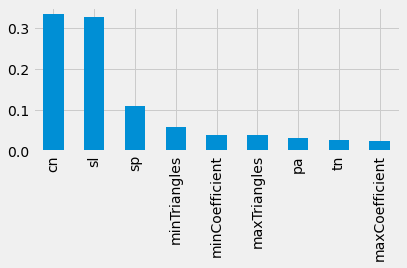

In [72]:
# tag::test-model[]
predictions = classifier.predict(df_test_under[columns])
y_test = df_test_under["label"]

display(evaluate_model(predictions, y_test))
feature_importance(columns, classifier)
# end::test-model[]